# 運動方程式を解く
\begin{align}
m\frac{d^2{\bf x}}{dt^2}={\bf F}
\end{align}
重力
\begin{align}
{\bf F}=-mg\hat{z}
\end{align}
を考える。全体を質量$m$で割って
\begin{align}
\frac{d^2{\bf x}}{dt^2}=-g\hat{z}
\end{align}
$x$-$z$平面に問題を限定し、初期位置を原点にとる。初速度はパラメータとし、$(v_{0x},v_{0z})$で表す。この方程式の解は、
\begin{align}
x(t) &= v_{0x}t \nonumber\\
z(t) &= v_{0z}t-\frac{1}{2}gt^2
\end{align}
となる。

In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import clear_output

In [0]:
class PlotLosses:
    def __init__(self):
        self.i = 0
        self.x = []
        self.losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def update(self, loss, epoch=None, log=True):
        self.x.append(self.i)
        self.losses.append(loss)
        if epoch is None:
            self.i += 1
        else:
            self.i = epoch
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        if log:
            plt.yscale("log")
        plt.xlabel("iteration", fontsize=14)
        plt.ylabel("Loss", fontsize=14)
        plt.legend(fontsize=14)
        plt.show()

In [0]:
class Solver:
    def __init__(self, N, t_f, v0_x_f, v0_z_f, layers):
        self.N = N
        
        self.t0 = np.zeros([N, 1])
        
        self.t_f_min = t_f[0]
        self.t_f_len = t_f[1] - t_f[0]
        self.v0_x_min = v0_x_f[0]
        self.v0_x_len = v0_x_f[1] - v0_x_f[0]
        self.v0_z_min = v0_z_f[0]
        self.v0_z_len = v0_z_f[1] - v0_z_f[0]
        
        self.t_f = self.t_f_len * np.random.rand(self.N, 1) + self.t_f_min
        self.v0_x = self.v0_x_len * np.random.rand(self.N, 1) + self.v0_x_min
        self.v0_z = self.v0_z_len * np.random.rand(self.N, 1) + self.v0_z_min
        
        X = np.concatenate([self.t_f, self.v0_x, self.v0_z], axis=1)
        
        self.lb = X.min(axis=0)
        self.ub = X.max(axis=0)
        
        # Initialize NN
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        self.v0_x_tf = tf.placeholder(tf.float32, shape=[None, self.v0_x.shape[1]])
        self.v0_z_tf = tf.placeholder(tf.float32, shape=[None, self.v0_z.shape[1]])
        
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])
        
        # tf Graphs
        self.result0 = self.net(self.t0_tf, self.v0_x_tf, self.v0_z_tf)
        self.x_pred, self.z_pred, self.vx_pred, self.vz_pred, _, _ = self.result0
        self.fx_pred, self.fz_pred = self.net_f(self.t_f_tf, self.v0_x_tf, self.v0_z_tf)
        
        # Loss
        self.loss0 = tf.reduce_mean(tf.square(self.x_pred)) + \
                     tf.reduce_mean(tf.square(self.z_pred)) + \
                     tf.reduce_mean(tf.square(self.v0_x_tf - self.vx_pred)) + \
                     tf.reduce_mean(tf.square(self.v0_z_tf - self.vz_pred)) 
        
        self.loss = tf.reduce_mean(tf.square(self.x_pred)) + \
                    tf.reduce_mean(tf.square(self.z_pred)) + \
                    tf.reduce_mean(tf.square(self.v0_x_tf - self.vx_pred)) + \
                    tf.reduce_mean(tf.square(self.v0_z_tf - self.vz_pred)) + \
                    tf.reduce_mean(tf.square(self.fx_pred)) + \
                    tf.reduce_mean(tf.square(self.fz_pred))
        
        # Optimizer
        self.count = 0
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
        self.plot_losses = PlotLosses()

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net(self, t, v0_x, v0_z):
        X = tf.concat([t, v0_x, v0_z], axis=1)
        
        xz = self.neural_net(X, self.weights, self.biases)
        
        x = xz[:,0:1]
        z = xz[:,1:2]
        
        x_t = tf.gradients(x, t)[0]
        x_tt = tf.gradients(x_t, t)[0]
        
        z_t = tf.gradients(z, t)[0]
        z_tt = tf.gradients(z_t, t)[0]

        return x, z, x_t, z_t, x_tt, z_tt

    def net_f(self, t, v0_x, v0_z):
        _, _, _, _, x_tt, z_tt = self.net(t, v0_x, v0_z)
        g = 9.8
        
        return x_tt, z_tt + g
    
    def callback(self, loss):
        if self.count % 100 == 0:
            elapsed = time.time() - self.start_time
            self.plot_losses.update(loss, self.nIter - 1 + self.count)
            print('L-BFGS-B It: %d, Loss: %.3e, Time: %.2f' % 
                  (self.count, loss, elapsed))
            self.start_time = time.time()
        self.count += 1
        
    def train(self, nIter):
        self.nIter = nIter
        tf_dict = {self.t0_tf: self.t0, self.v0_x_tf: self.v0_x,
                   self.v0_z_tf: self.v0_z,
                   self.t_f_tf: self.t_f}
                                                                                                                          
        self.start_time = time.time()
#         self.optimizer.minimize(self.sess, 
#                                 feed_dict = tf_dict,         
#                                 fetches = [self.loss0], 
#                                 loss_callback = self.callback)
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)
        
        start_time = time.time()
        for it in range(nIter):
            
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 100 == 0:
                self.t_f = self.t_f_len * np.random.rand(self.N, 1) + self.t_f_min
                self.v0_x = self.v0_x_len * np.random.rand(self.N, 1) + self.v0_x_min
                self.v0_z = self.v0_z_len * np.random.rand(self.N, 1) + self.v0_z_min
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                
                self.plot_losses.update(loss_value, it)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
        
    def predict(self, t, v0_x, v0_z):
        t = np.expand_dims(t, axis=1)
        v0_x = np.expand_dims(v0_x, axis=1)
        v0_z = np.expand_dims(v0_z, axis=1)
        tf_dict = {self.t0_tf: t, self.v0_x_tf: v0_x, self.v0_z_tf: v0_z}
        
        x, z, vx, vz, _, _ = self.sess.run(self.result0, tf_dict)
        def squeeze(x):
            return np.squeeze(x, axis=1)
        x, z, vx, vz = list(map(squeeze, [x, z, vx, vz]))
        
        return x, z, vx, vz

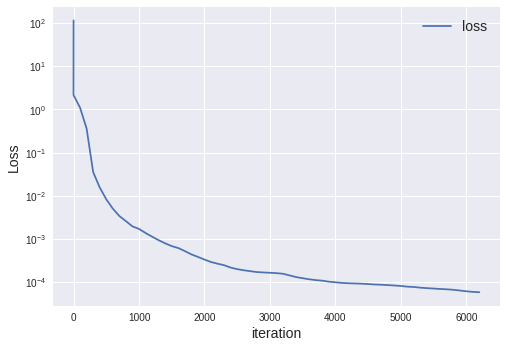

L-BFGS-B It: 6300, Loss: 5.861e-05, Time: 4.06
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000059
  Number of iterations: 5799
  Number of functions evaluations: 6324


In [4]:
N = 10000
t_f = [0, 1]
v_x0_f = [0, 5]
v_z0_f = [0, 5]

layers = [20] * 8
layers = [3, *layers, 2]
solver = Solver(N, t_f, v_x0_f, v_z0_f, layers)
solver.train(0)

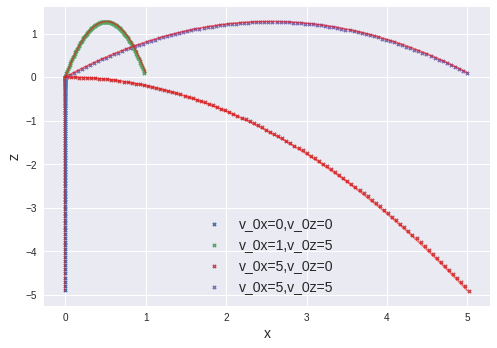

In [5]:
for v0_x, v0_z in [(0, 0), (1, 5), (5, 0), (5, 5)]:
    N = 100
    t = np.linspace(0, 1, N)
    v0_x = v0_x * np.ones(N)
    v0_z = v0_z * np.ones(N)

    x, z, _, _ = solver.predict(t, v0_x, v0_z)

    x_exact = v0_x * t
    z_exact = v0_z * t - 9.8 * t ** 2 / 2

    plt.scatter(x, z, s=10, marker="x", label="v_0x={:.0f},v_0z={:.0f}".format(v0_x[0], v0_z[0]))
    plt.plot(x_exact, z_exact, alpha=0.5, c="r")
plt.legend(fontsize=14)
plt.xlabel("x", fontsize=14)
plt.ylabel("z", fontsize=14)
plt.show()

#エネルギー保存則
運動方程式に従う運動は全エネルギーが保存される。すなわち、運動エネルギー
\begin{align}
E_V=\frac{1}{2}m|{\bf v}|^2
\end{align}
と位置エネルギー
\begin{align}
E_U=mgz
\end{align}
の和が保存される。$(v_{0x},v_{0z})=(5,5)$の場合にこれが成り立つことを確かめよう。

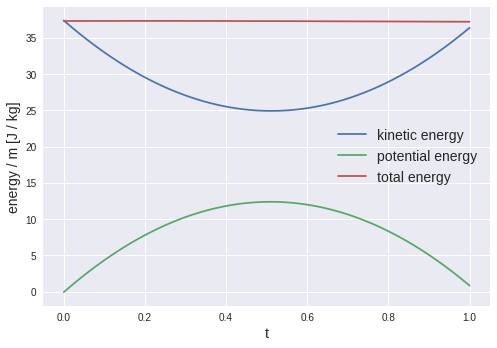

In [6]:
N = 100
t = np.linspace(0, 1, N)
v0_x = v0_x * np.ones(N)
v0_z = v0_z * np.ones(N)

_, z, vx, vz = solver.predict(t, v0_x, v0_z)

E_V = vx ** 2 + vz ** 2 / 2
E_U = 9.8 * z

plt.plot(t, E_V, label="kinetic energy")
plt.plot(t, E_U, label="potential energy")
plt.plot(t, E_V + E_U, label="total energy")
plt.legend(fontsize=14)
plt.xlabel("t", fontsize=14)
plt.ylabel("energy / m [J / kg]", fontsize=14)
plt.show()

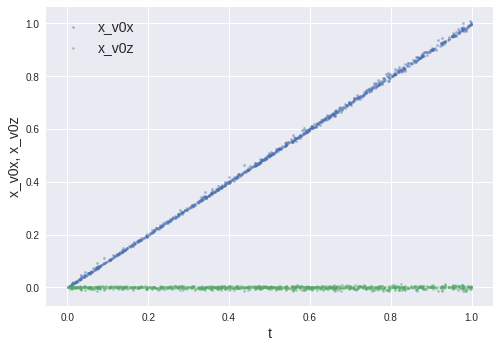

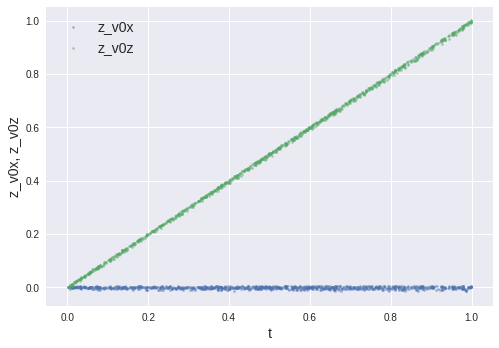

In [18]:
def get_dr_dv0(t, v0_x, v0_z):
    t = np.expand_dims(t, axis=1)
    v0_x = np.expand_dims(v0_x, axis=1)
    v0_z = np.expand_dims(v0_z, axis=1)
    tf_dict = {solver.t0_tf: t, solver.v0_x_tf: v0_x, solver.v0_z_tf: v0_z}
    x, z, _, _, _, _ = solver.result0
    dr_dv0_tf = [tf.gradients(x, solver.v0_x_tf)[0], tf.gradients(x, solver.v0_z_tf)[0],
                 tf.gradients(z, solver.v0_x_tf)[0], tf.gradients(z, solver.v0_z_tf)[0]]
    dr_dv0 = solver.sess.run(dr_dv0_tf, tf_dict)
    
    def squeeze(x):
        return np.squeeze(x, axis=1)
    dr_dv0 = list(map(squeeze, dr_dv0))
    
    return dr_dv0

N = 1000
t = np.random.rand(N)
v0_x = 5 * np.random.rand(N)
v0_z = 5 * np.random.rand(N)

x_vx, x_vz, z_vx, z_vz = get_dr_dv0(t, v0_x, v0_z)

plt.scatter(t, x_vx, s=5, alpha=0.5, label="x_v0x")
plt.scatter(t, x_vz, s=5, alpha=0.5, label="x_v0z")
plt.legend(fontsize=14)
plt.xlabel("t", fontsize=14)
plt.ylabel("x_v0x, x_v0z", fontsize=14)
plt.show()

plt.scatter(t, z_vx, s=5, alpha=0.5, label="z_v0x")
plt.scatter(t, z_vz, s=5, alpha=0.5, label="z_v0z")
plt.legend(fontsize=14)
plt.xlabel("t", fontsize=14)
plt.ylabel("z_v0x, z_v0z", fontsize=14)
plt.show()